In [2]:
import cPickle as pickle
import os

from sigvisa import Sigvisa



In [3]:
s = Sigvisa()

mcmc_run = 1753
step = 539
mcmc_log_dir = os.path.join(s.homedir, "logs", "mcmc")
mcmc_run_dir = os.path.join(mcmc_log_dir, "%05d" % mcmc_run)
sgfile = os.path.join(mcmc_run_dir, "step_%06d/pickle.sg" % step)
with open(sgfile, 'rb') as f:
    sg = pickle.load(f)

In [4]:
print sg.station_waves.keys()

['MK31', 'CM16', 'BVA0', 'WR1', 'AKTO', 'ZAA0', 'FITZ', 'CTA', 'INK', 'SONA0', 'AS12', 'KURBB']


# Model evidence for GP wiggle predictions

In [5]:
sta="MK31"
chan="BHZ"
band="freq_0.8_4.5"
phase="P"

eids = sg.evnodes.keys()

eid_wiggle_posteriors = dict()

wiggle_gpmodels = dict([(k, v) for (k, v) in sg._joint_gpmodels[sta].items() if k.startswith("db")])

holdout_evidence = dict()

for eid in eids:
    try:
        holdout_evidence[eid] = np.sum([jgp.holdout_evidence(eid) for jgp in wiggle_gpmodels.values()])
    except KeyError:
        continue

"""
n = len(eids)
pairwise_evidence = np.zeros((n,n))
for i, eid1 in enumerate(eids):
    for j, eid2 in enumerate(eids):
        pairwise_evidence[i,j] = 0
        pairwise_evidence[j,i] = 0
        for jgp in wiggle_gpmodels.values():
            p1, p2 =  jgp.pairwise_evidence(eid1, eid2)
            # evidence for row|col
            pairwise_evidence[i,j] += p1 # evidence for eid1|eid2
            pairwise_evidence[j,i] += p2 # evidence for eid2|eid1
"""

'\nn = len(eids)\npairwise_evidence = np.zeros((n,n))\nfor i, eid1 in enumerate(eids):\n    for j, eid2 in enumerate(eids):\n        pairwise_evidence[i,j] = 0\n        pairwise_evidence[j,i] = 0\n        for jgp in wiggle_gpmodels.values():\n            p1, p2 =  jgp.pairwise_evidence(eid1, eid2)\n            # evidence for row|col\n            pairwise_evidence[i,j] += p1 # evidence for eid1|eid2\n            pairwise_evidence[j,i] += p2 # evidence for eid2|eid1\n'

In [6]:
print holdout_evidence

{1: 20.618980643308337, 2: 21.297701963662821, 3: 15.366481385924835, 4: 0.0, 5: 0.0, 6: 1.4299672557172016e-12, 7: 4.6367931851201014, 8: 0.0, 9: 6.6363962603404714, 10: 0.0, 11: 5.4409809990829672e-12, 12: -1.5965540001161571e-10, 13: -0.0038472215837064283, 14: 9.5633738671190542, 15: 2.6660545032743084, 16: 0.0, 17: -0.10203450101685085, 18: 0.0, 19: -0.4418813805631141, 20: 19.430183174506414, 21: 16.011730591606675, 22: 21.776101957525562, 23: 3.5348829903964489, 24: -6.8355809901277098e-10, 25: 17.803655210634354, 26: -1.2564868482346421, 27: 0.0, 28: 16.85660664653939, 29: 0.0, 30: -1.2003855687225951e-09, 31: 2.3320869998004281, 32: 1.5081413410087348, 33: 23.761456637546935}


In [7]:
imshow(pairwise_evidence, interpolation=None)

NameError: name 'pairwise_evidence' is not defined

In [8]:
# NEXT TODO: actually realize the inferred wiggles and correlate them
# (NOT cross-correlation since we expect to have actually found alignments)
# (could also try realizing the actual wiggled templates)

# Correlations of inferred wiggles

In [13]:
from sigvisa.models.wiggles.uniform_variance_wavelets import implicit_to_explicit


(starray, etarray, idarray, M, N), iid_std = sg.station_waves.values()[0][0].wavelet_basis
prototypes = [np.asarray(m).flatten() for m in M]


basis = implicit_to_explicit(starray, etarray, idarray, prototypes, N)


In [111]:
def plot_wavelet_dist_samples(ax, srate, basis, wmeans, wvars, c="blue"):
    wmeans = np.asarray(wmeans).flatten()
    wvars = np.asarray(wvars).flatten()
    
    n = basis.shape[1]
    x = np.linspace(0, n/float(srate), n)
    for n in range(30):
        ws = np.random.randn(basis.shape[0])*np.sqrt(wvars)+wmeans
        w = np.dot(basis.T, ws) + 1
        ax.plot(x, w, c=c, linestyle="-", alpha=0.2, lw=3)
        
        
def plot_wavelet_dist(ax, srate, basis, wmeans, wvars, c="blue"):
    wmeans = np.asarray(wmeans).flatten()
    wvars = np.asarray(wvars).flatten()
    
    w = np.dot(basis.T, wmeans) + 1
    wv = np.diag(np.dot(basis.T, np.dot(np.diag(wvars), basis)))
    n = basis.shape[1]
    x = np.linspace(0, n/float(srate), n)
    ax.plot(x, w, c=c, linestyle="-", lw=2)
    ax.fill_between(x, w+2*np.sqrt(wv), w-2*np.sqrt(wv), facecolor=c, alpha=0.2)


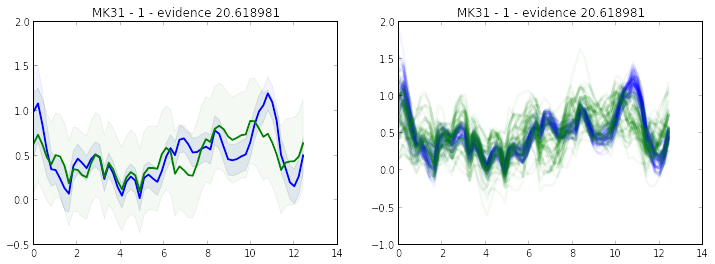

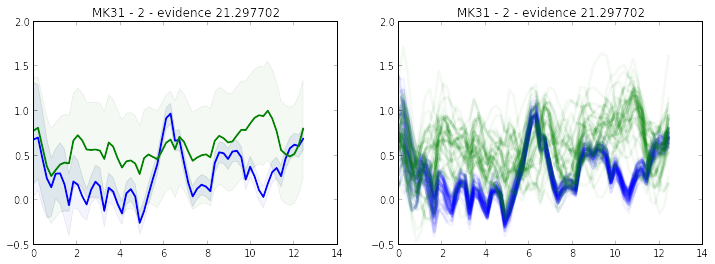

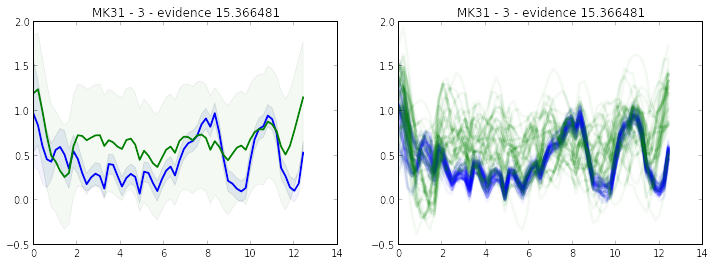

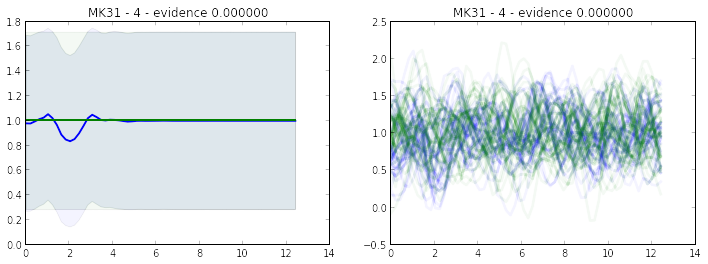

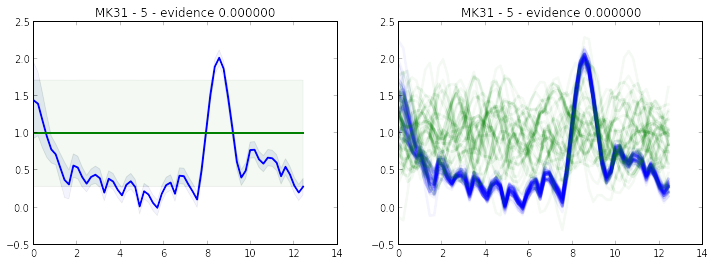

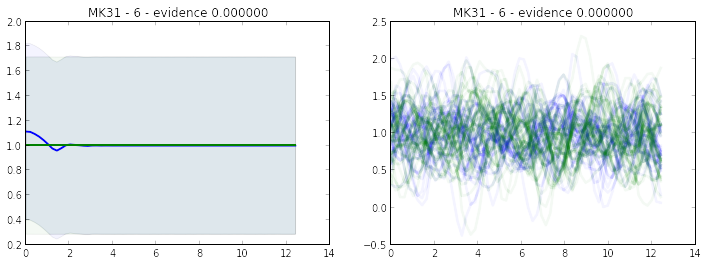

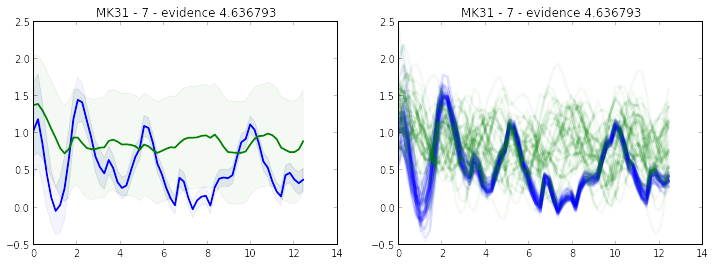

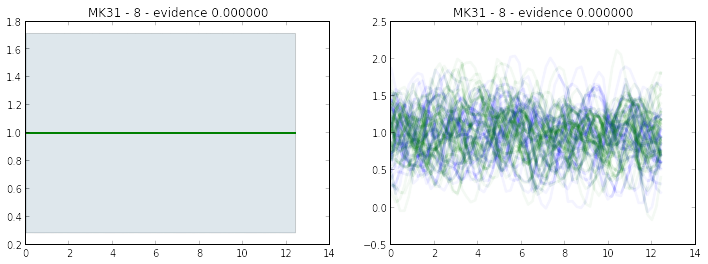

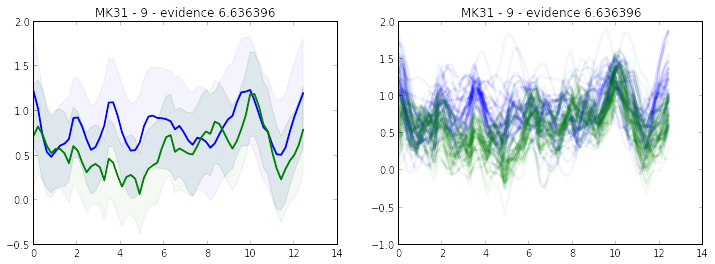

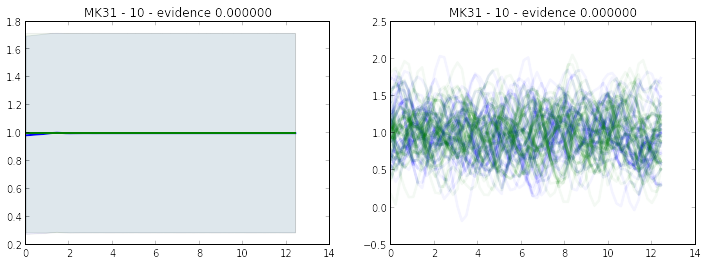

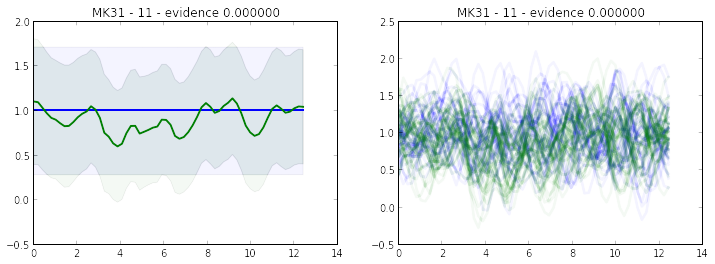

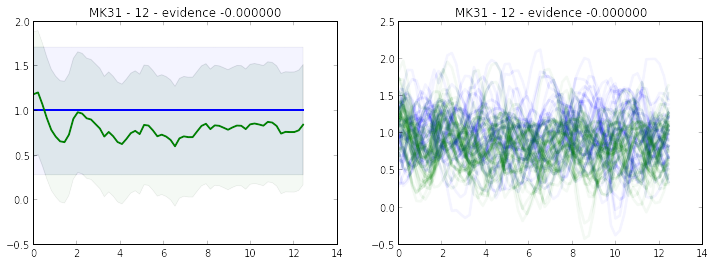

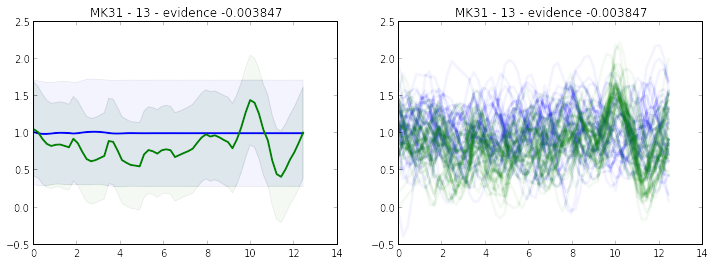

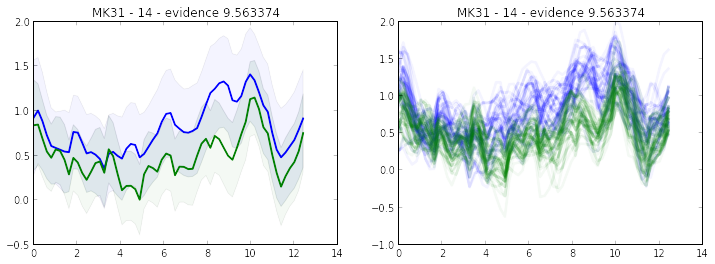

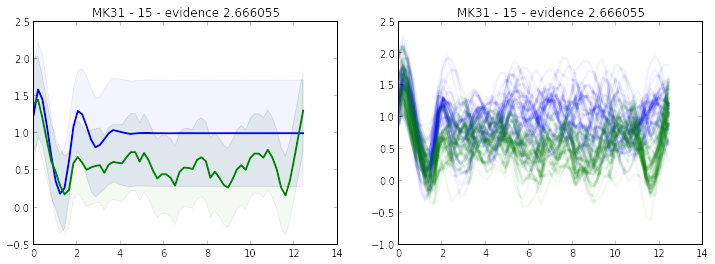

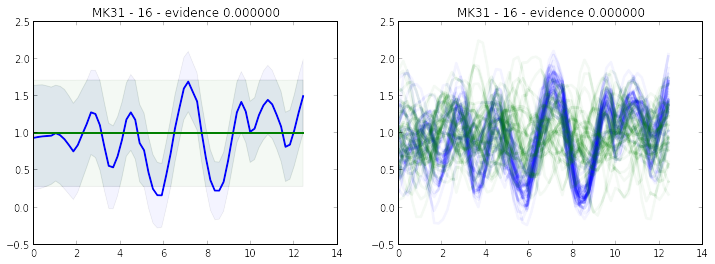

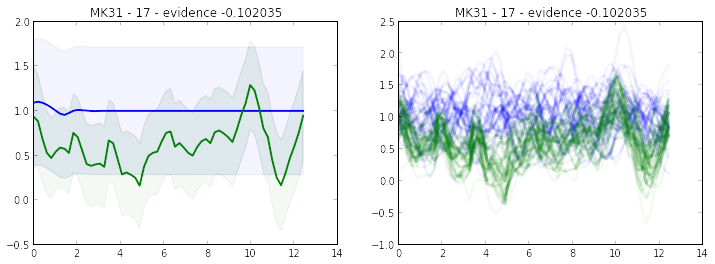

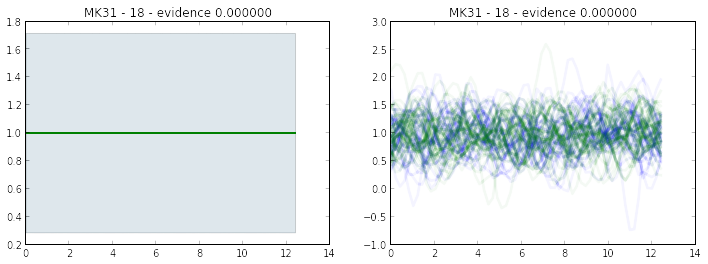

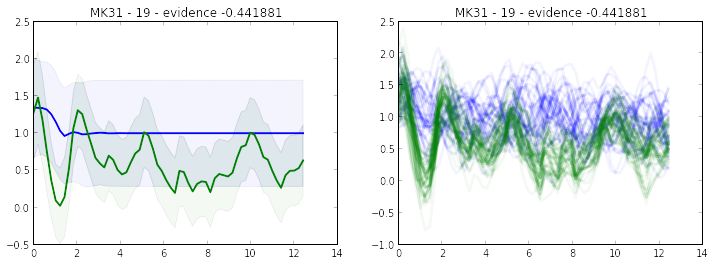

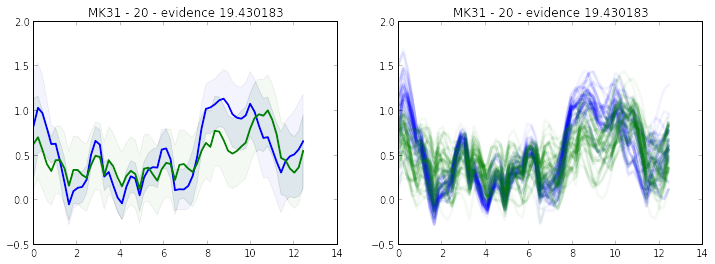

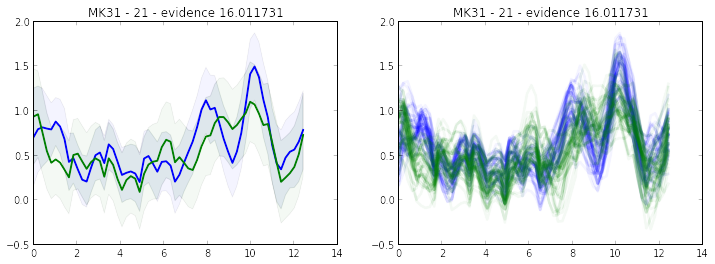

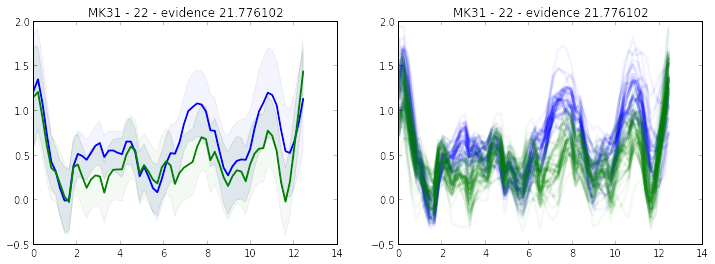

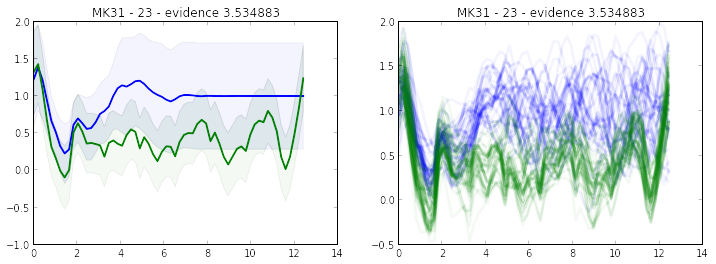

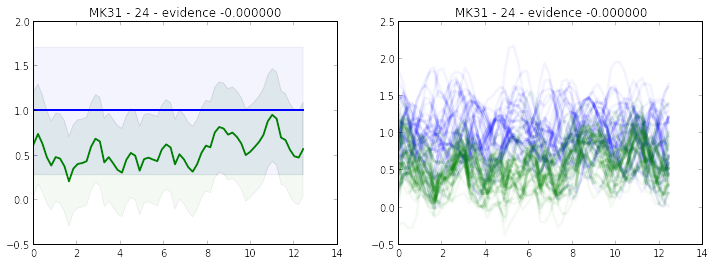

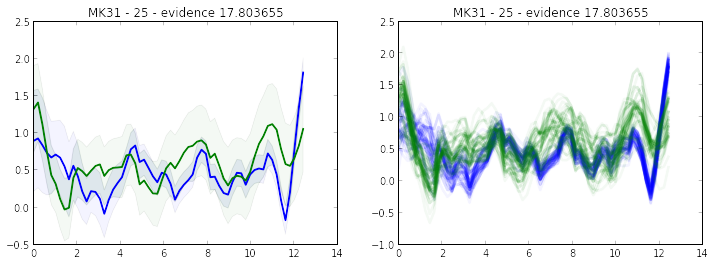

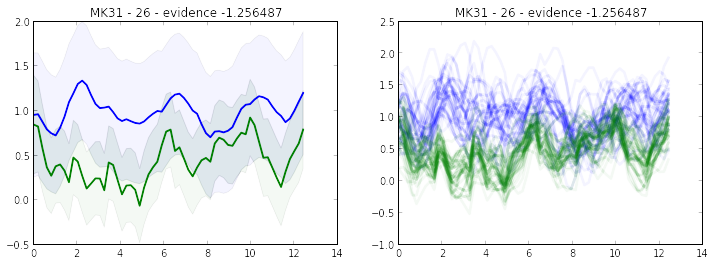

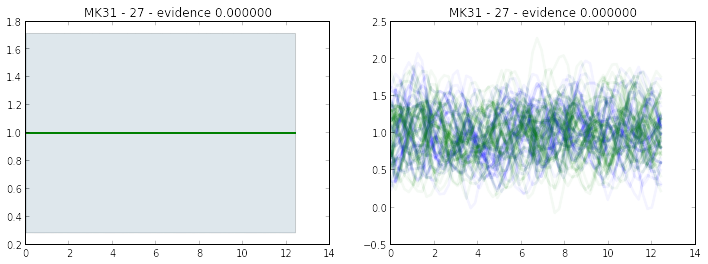

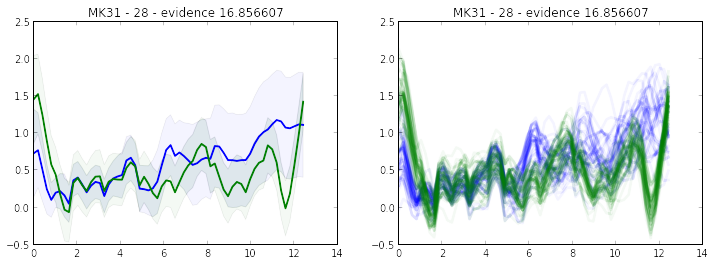

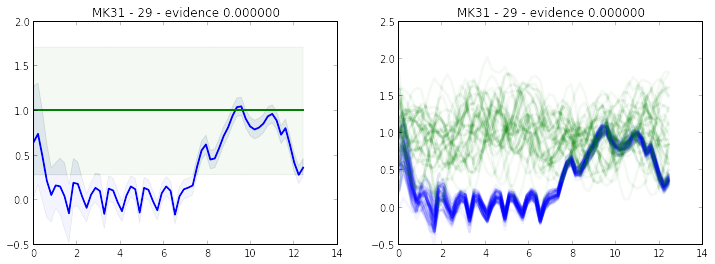

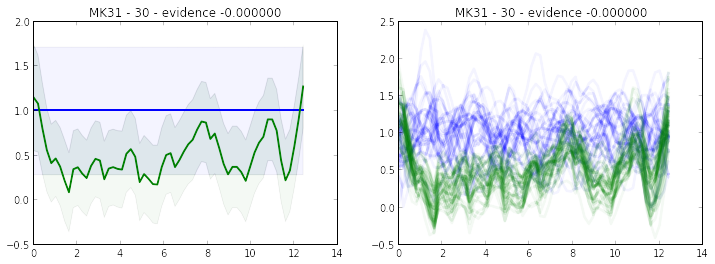

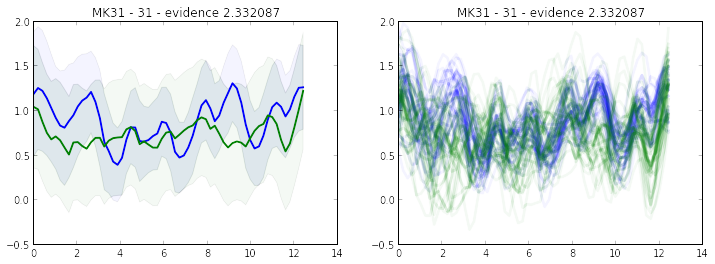

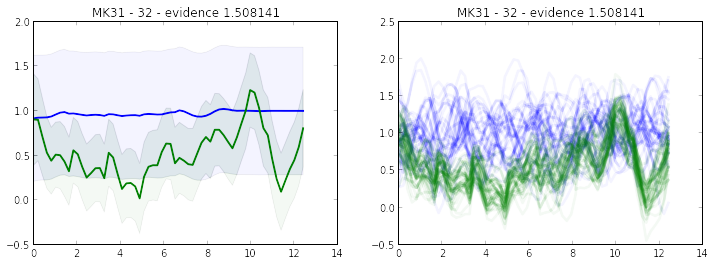

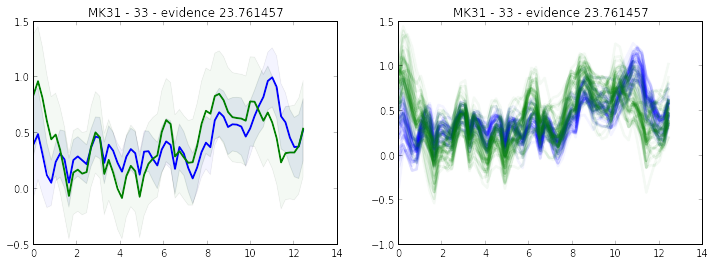

In [112]:
for wn in sg.station_waves[sta]:
    wn.pass_jointgp_messages()
    ell, prior_means, prior_vars, posterior_means, posterior_vars = wn._coef_message_cache
    
    for i, (eid, phase, _, _, _, ctype) in enumerate(wn.tssm_components):
        if ctype != "wavelet": continue
        cond_means, cond_vars = zip(*[jgp.posterior(eid) for jgp in wn.wavelet_param_models[phase]])

        f = figure(figsize=(12, 4))
        ax = f.add_subplot(121)
        plot_wavelet_dist(ax, wn.srate, basis, posterior_means, posterior_vars, c="blue")
        plot_wavelet_dist(ax, wn.srate, basis, cond_means, cond_vars, c="green")
        ax.set_title("%s - %d - evidence %f" % (sta, eid, holdout_evidence[eid]))
        ax = f.add_subplot(122)
        plot_wavelet_dist_samples(ax, wn.srate, basis, posterior_means, posterior_vars, c="blue")
        plot_wavelet_dist_samples(ax, wn.srate, basis, cond_means, cond_vars, c="green")
        ax.set_title("%s - %d - evidence %f" % (sta, eid, holdout_evidence[eid]))


26

In [32]:
def flatten_cov(C):
    n = C.shape[0]
    flat = np.empty(((n*(n+1))/2))

    L = np.linalg.cholesky(C)
    print L
    
    idx = 0
    for i in range(n):
        col = L[i:, i]
        flat[idx:idx+len(col)] = col
        idx += len(col)
    return flat

def unflatten_cov(flat):
    n = int((np.sqrt(1+8*len(flat)) - 1)/2)
    L = np.zeros((n,n))

    idx = 0
    for i in range(n):
        L[i:, i] = flat[idx:idx+(n-i)]
        idx += n-i
    print L
        
    C = np.dot(L, L.T)
    return C

In [33]:

L = np.random.randn(3, 3)
C = np.dot(L, L.T)
f = flatten_cov(C)
C2 = unflatten_cov(f)
print C-C2

[[ 1.73424967  0.          0.        ]
 [-0.12098342  1.6883074   0.        ]
 [-1.42512108 -1.05866249  0.99998315]]
[[ 1.73424967  0.          0.        ]
 [-0.12098342  1.6883074   0.        ]
 [-1.42512108 -1.05866249  0.99998315]]
[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
